# Covid19 Investigation

Set some key parameters:

In [45]:
mortality_rate = 2.5  # In %; see near the end for how I determined this
days_to_first_symptom = 5 # 5.4 days is the average value I have seen cited
days_from_first_symptom_to_death = 14  # again, the average

In [46]:
state_pop = {  # From https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population
    'AL': 4903185,
    'AK': 731545,
    'AZ': 7278717,
    'AR': 3017825,
    'CA': 39512223,
    'CO': 5758736,
    'CT': 3565287,
    'D.C.': 705749,
    'DE': 973764,
    'FL': 21477737,
    'GA': 10617423,
    'HI': 1415872,
    'ID': 1787065,
    'IL': 12671821,
    'IN': 6732219,
    'IA': 3155070,
    'KS': 2913314,
    'KY': 4467673,
    'LA': 4648794,
    'ME': 1344212,
    'MD': 6045680,
    'MA': 6949503,
    'MI': 9986857,
    'MN': 5639632,
    'MS': 2976149,
    'MO': 6137428,
    'MT': 1068778,
    'NE': 1934408,
    'NV': 3080156,
    'NH': 1359711,
    'NJ': 8882190,
    'NM': 2096829,
    'NY': 19453561,
    'NC': 10488084,
    'ND': 762062,
    'OH': 11689100,
    'OK': 3956971,
    'OR': 4217737,
    'PA': 12801989,
    'PR': 3193694,
    'RI': 1059361,
    'SC': 5148714,
    'SD': 884659,
    'TN': 6833174,
    'TX': 28995881,
    'UT': 3205958,
    'VT': 623989,
    'VA': 8535519,
    'WA': 7614893,
    'WV': 1792147,
    'WI': 5822434,
    'WY': 578759,
    'U.S.': 2800000 # other territories
}


Import dependencies:

In [47]:
from datetime import date, datetime, timedelta
import os
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import ipywidgets as widgets
from scipy.optimize import curve_fit
from scipy.integrate import odeint


register_matplotlib_converters()
%matplotlib inline

Fetch the latest updated data from the Johns Hopkins repo.

In [48]:
df = None
last = datetime.now() - timedelta(hours=1)

In [49]:
def get_data():
    """
    Get the latest data. Just return the cached copy
    if less than one hour has elapsed.
    """
    global last, df
    now = datetime.now()
    if df is not None and now - last < timedelta(hours=1):
        print('Using cached copy')
        return df

    if not os.path.exists('csse_covid_19_daily_reports'):
        os.mkdir('csse_covid_19_daily_reports')
        
    last = now    
    start = date(2020, 1, 22)
    end = date.today()

    df = pd.DataFrame()
    while start <= end:
        try:
            which = f'csse_covid_19_daily_reports/{start.month:02d}-{start.day:02d}-{start.year}.csv'
            if os.path.exists(which):
                df_day = pd.read_csv(which)
            else:
                df_day = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/{which}')
                df_day.to_csv(which)
            df_day['Date'] = start
            if 'Country_Region' in df_day.columns:
                df_day = df_day.rename(columns={'Country_Region': 'Country/Region', 'Province_State': 'Province/State'})
            df = df.append(df_day)
        except Exception as e:
            print(f'{start}: {e}')
        start += timedelta(days=1)
    
    del df['Last Update']
    df = df.replace({'Country/Region': {'Mainland China': 'China'}})
    df.fillna({'Province/State': ''}, inplace=True)
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        df.fillna({col: 0}, inplace=True)
    return df

In [50]:
df = get_data()

clean = [' Azerbaijan', 'Aruba', 'Bahamas', 'Bahamas, The', 'Barbados', 'Belize', 'Benin', 'Bhutan',
         'Botswana', 'Burma', 'Burundi', 'Cabo Verde', 'Cape Verde', 'Cayman Islands', 'Channel Islands',
         'Comoros', 'Cruise Ship', 'Curacao', 'Diamond Princess', 'Dominica', 'East Timor', 'Eritrea',
         'Faroe Islands', 'Fiji', 'French Guiana', 'Gambia, The', 'Gibraltar', 'Greenland', 'Grenada',
         'Guadeloupe', 'Guam', 'Guernsey', 'Holy See', 'Hong Kong SAR', 'Iran (Islamic Republic of)', 
         'Ivory Coast', 'Jersey', 'Laos', 'MS Zaandam', 'Macao SAR', 'Macau', 'Martinique', 'Mayotte',
         'North Ireland', 'Others', 'Palestine', 'Papua New Guinea', 'Puerto Rico', 'Republic of Ireland',
         'Republic of Korea', 'Republic of Moldova', 'Republic of the Congo', 'Reunion', 'Russian Federation',
         'Saint Barthelemy', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin', 'Saint Vincent and the Grenadines',
         'Sao Tome and Principe', 'Seychelles', 'St. Martin', 'Suriname', 'Taipei and environs', 'The Bahamas',
         'The Gambia', 'Timor-Leste', 'Trinidad and Tobago', 'UK', 'Vatican City', 'Viet Nam',
         'Western Sahara', 'occupied Palestinian territory']

df = df[~df['Country/Region'].isin(clean)]

df.tail(5)

2020-10-09: HTTP Error 404: Not Found


,Unnamed: 0,Province/State,Country/Region,Confirmed,Deaths,Recovered,Date,Latitude,Longitude,FIPS,...,Long_,Active,Combined_Key,Incident_Rate,People_Tested,People_Hospitalized,UID,ISO3,Incidence_Rate,Case-Fatality_Ratio
3949,NaN,,Vietnam,1100.0,35.0,1023.0,2020-10-08,NaN,NaN,NaN,...,108.277199,42.0,Vietnam,NaN,NaN,NaN,NaN,NaN,1.130076,3.181818
3950,NaN,,West Bank and Gaza,43256.0,359.0,36584.0,2020-10-08,NaN,NaN,NaN,...,35.233200,6313.0,West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,847.921440,0.829943
3952,NaN,,Yemen,2050.0,593.0,1329.0,2020-10-08,NaN,NaN,NaN,...,48.516388,128.0,Yemen,NaN,NaN,NaN,NaN,NaN,6.873205,28.926829
3953,NaN,,Zambia,15301.0,335.0,14365.0,2020-10-08,NaN,NaN,NaN,...,27.849332,601.0,Zambia,NaN,NaN,NaN,NaN,NaN,83.230182,2.189399
3954,NaN,,Zimbabwe,7951.0,229.0,6446.0,2020-10-08,NaN,NaN,NaN,...,29.154857,1276.0,Zimbabwe,NaN,NaN,NaN,NaN,NaN,53.495519,2.880141


Because the JH data is split by sub-regions (Province/State) we need to be able to aggregate it for countries. We also want to be able to handle it as either "daily new" or "cumulative". The helper function below can do this for us.

In [51]:
def aggregate_for_locations(df, locations, sub_locs=None, how=None, fields=None, pop=None):
    if how is None:
        how = 'cumulative'
    if fields is None:
        fields = ['Confirmed', 'Deaths', 'Recovered']
    cols = ['Date']
    cols.extend(fields)
    
    if isinstance(locations, str):
        locations = [locations]
        
    if sub_locs:
        if isinstance(sub_locs, str):
            sub_locs = [sub_locs]
        in_loc = df[(df['Country/Region'].isin(locations)) & (df['Province/State'].isin(sub_locs))]
    else:
        in_loc = df[df['Country/Region'].isin(locations)]
        
    result = in_loc[cols].groupby('Date').sum()
    
    if how[:3] == 'new':
        for f in fields:
            result[f] = result[f].diff()

    if how.find('-') > 0 and how[how.find('-')+1:] == '7day':  # moving average
        rolling = result.rolling(window=7)
        for f in fields:
            result[f] = rolling[f].mean()
    for f in fields:
        result.fillna({f: 0}, inplace=True)   
        if pop is not None:
            result[f] /= pop
            
    return result


Helper function to plot a time series chart:

In [52]:
def plot_time_series(df, title):
    fig, ax = plt.subplots()
    ax.plot_date(df.index, df, 'v-')
    ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1), interval=1))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
    ax.legend(df.columns, loc='upper left', shadow=True)
    ax.set_title(title)
    plt.tight_layout()
    return plt

Get the set of possible Country/Region values:

In [53]:
locations = sorted(list(df['Country/Region'].unique()))

We have one chart that lets us drill down into US states so we need the list of those. In some cases the data is broken into cities/counties, so we build up a dictionary of state abbreviations to the set of locations used for that state:

In [54]:
states = {
    'AL': ['Alabama'],
    'AK': ['Alaska'],
    'AZ': ['Arizona'],
    'AR': ['Arkansas'],
    'CA': ['California'],
    'CO': ['Colorado'],
    'CT': ['Connecticut'],
    'D.C.': ['District of Columbia'],
    'DE': ['Delaware'],
    'FL': ['Florida'],
    'GA': ['Georgia'],
    'HI': ['Hawaii'],
    'ID': ['Idaho'],
    'IL': ['Illinois'],
    'IN': ['Indiana'],
    'IA': ['Iowa'],
    'KS': ['Kansas'],
    'KY': ['Kentucky'],
    'LA': ['Louisiana'],
    'ME': ['Maine'],
    'MD': ['Maryland'],
    'MA': ['Massachusetts'],
    'MI': ['Michigan'],
    'MN': ['Minnesota'],
    'MS': ['Mississippi'],
    'MO': ['Missouri'],
    'MT': ['Montana'],
    'NE': ['Nebraska'],
    'NV': ['Nevada'],
    'NH': ['New Hampshire'],
    'NJ': ['New Jersey'],
    'NM': ['New Mexico'],
    'NY': ['New York'],
    'NC': ['North Carolina'],
    'ND': ['North Dakota'],
    'OH': ['Ohio'],
    'OK': ['Oklahoma'],
    'OR': ['Oregon'],
    'PA': ['Pennsylvania'],
    'PR': ['Puerto Rico'],
    'RI': ['Rhode Island'],
    'SC': ['South Carolina'],
    'SD': ['South Dakota'],
    'TN': ['Tennessee'],
    'TX': ['Texas'],
    'UT': ['Utah'],
    'VT': ['Vermont'],
    'VA': ['Virginia'],
    'WA': ['Washington'],
    'WV': ['West Virginia'],
    'WI': ['Wisconsin'],
    'WY': ['Wyoming'],
    'U.S.': [] # other territories
}


# Extend the above with all the counties/cities that were broken out separately
for s in df[df['Country/Region'] == 'US']['Province/State'].unique():
    i = s.find(',')
    if i < 0:
        continue
    st = s[i+2:i+5].strip()
    if st not in states:
        st += '.'
        if st not in states:
            print(f'Failed with {s}/{st}')
            continue
    states[st].append(s)


Create a country multi-picker:

In [55]:
picker = widgets.SelectMultiple(
                        options=locations,
                        value=['US'],
                        description='Locations'
                )

Our first interactive chart is for one or more countries, cumulative cases:

In [56]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, Location, how='cumulative'), 
                                                   title=f'{" ".join(Location)}: Cumulative'),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

As above, but new cases rather than cumulative:

In [57]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, Location, how='new'), 
                                                   title=f'{" ".join(Location)}: New'),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [58]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, Location, how='new-7day'), 
                                                   title=f'{" ".join(Location)}: New (7-day MA)'),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

There are so many infections its hard to see the deaths, so pull those out separately:

In [59]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, Location, fields=['Deaths'], how='new'), 
                                                   title=f'{" ".join(Location)}: New'),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [60]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, Location, how='new-7day',
                                                                          fields=['Deaths']), 
                                                   title=f'{" ".join(Location)}: New (7-day MA)'),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

A chart for cumulative cases in different US states:

In [61]:
picker2 = widgets.SelectMultiple(
                        options=states.keys(),
                        value=['WA'],
                        description='States'
                )

def normalize_states(locs):
    rtn = []
    for loc in locs:
        rtn.extend(states[loc])
    return rtn


widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, 'US', 
                                                   sub_locs=normalize_states(Location), how='cumulative'), 
                                                   title=f'{Location}: Cumulative'),
                 Location=picker2)

interactive(children=(SelectMultiple(description='States', index=(48,), options=('AL', 'AK', 'AZ', 'AR', 'CA',…

<function __main__.<lambda>(Location)>

In [62]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, 'US', 
                                                   sub_locs=normalize_states(Location), how='new'), 
                                                   title=f'{Location}: New'),
                 Location=picker2)

interactive(children=(SelectMultiple(description='States', index=(48,), options=('AL', 'AK', 'AZ', 'AR', 'CA',…

<function __main__.<lambda>(Location)>

In [63]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, 'US', 
                                                   sub_locs=normalize_states(Location), how='new-7day'), 
                                                   title=f'{Location}: New (7-day Moving Average)'),
                 Location=picker2)

interactive(children=(SelectMultiple(description='States', index=(48,), options=('AL', 'AK', 'AZ', 'AR', 'CA',…

<function __main__.<lambda>(Location)>

In [64]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, 'US', 
                                                   sub_locs=normalize_states(Location), how='new-7day', 
                                                   pop=sum([state_pop[s] for s in Location])/100000), 
                                                   title=f'{Location}: New (7-day Moving Average as rate per 100k)'),
                 Location=picker2)

interactive(children=(SelectMultiple(description='States', index=(48,), options=('AL', 'AK', 'AZ', 'AR', 'CA',…

<function __main__.<lambda>(Location)>

In [65]:
def get_rates(how='cumulative', sortby='Infected'):
    rate_df = pd.DataFrame()
    loc = []
    new = []
    died = []
    for state, pop in state_pop.items():
        df2 = aggregate_for_locations(df, 'US', sub_locs=normalize_states([state]), how=how, pop=pop/100000)
        last = df2.iloc[-1]
        loc.append(states[state][0])
        new.append(last['Confirmed'])
        died.append(last['Deaths'])
        #print(last)
        #rate_df.append({'State': state, 'New': last['Confirmed'], 'Died': last['Deaths'], 'Recovered': last['Recovered']}, ignore_index=True)

    rate_df = pd.DataFrame({'State': loc, 'Infected': new, 'Died': died})
    rate_df = rate_df.sort_values(by=sortby, ascending=False).reset_index()
    del rate_df['index']
    return rate_df


In [66]:
get_rates()  # Get states ordered by overall infection rate

,State,Infected,Died
0,Louisiana,3670.220707,120.654948
1,Mississippi,3454.766546,103.287839
2,Florida,3380.304918,70.156367
3,North Dakota,3330.962573,40.679105
4,Alabama,3303.464993,53.781369
5,Georgia,3083.676708,68.698403
6,Arizona,3069.235966,78.901268
7,Tennessee,3065.149519,39.586289
8,Iowa,3063.545341,45.418961
9,South Carolina,3005.702006,68.250052


In [67]:
get_rates(how='new-7day') # Get states ordered by recent infection rate

,State,Infected,Died
0,North Dakota,59.350252,1.012291
1,South Dakota,53.370039,0.581338
2,Montana,42.465053,0.213862
3,Wisconsin,40.898458,0.186471
4,Utah,35.188947,0.187152
5,Idaho,30.896630,0.247813
6,Nebraska,28.609713,0.155086
7,Iowa,28.204038,0.303367
8,Missouri,28.120202,0.451562
9,Oklahoma,25.975857,0.180513


In [68]:
get_rates(sortby='Died')

,State,Infected,Died
0,New Jersey,2377.206522,181.948371
1,New York,2416.544714,170.801634
2,Massachusetts,1970.443066,137.635742
3,Connecticut,1675.825817,126.974350
4,Louisiana,3670.220707,120.654948
5,Rhode Island,2458.557564,106.384887
6,Mississippi,3454.766546,103.287839
7,District of Columbia,2233.797001,89.833638
8,Arizona,3069.235966,78.901268
9,Illinois,2473.432982,72.278483


In [69]:
get_rates(how='new-7day', sortby='Died')

,State,Infected,Died
0,North Dakota,59.350252,1.012291
1,South Dakota,53.370039,0.581338
2,Arkansas,25.202635,0.563320
3,Mississippi,18.878663,0.456006
4,Missouri,28.120202,0.451562
5,Tennessee,25.119053,0.426491
6,Florida,11.220256,0.415048
7,Kansas,19.550636,0.367770
8,South Carolina,17.846343,0.316306
9,Texas,15.281974,0.313838


In [70]:
widgets.interact(lambda Location: plot_time_series(aggregate_for_locations(df, 'US',
                                                   sub_locs=normalize_states(Location),
                                                   fields=['Deaths'], how='new-7day'), 
                                                   title=f'{Location}: New'),
                 Location=picker2)

interactive(children=(SelectMultiple(description='States', index=(48,), options=('AL', 'AK', 'AZ', 'AR', 'CA',…

<function __main__.<lambda>(Location)>

Now we use the reported deaths to try to infer the actual number infected. We first different curves to the death counts and use that to extrapolate:

In [71]:
def exponential(x, a):
    return a ** x


def power(x, a):
    return x ** a


def linear(x, m, c):
    return x * m + c


def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)


def sigmoid_init(x, y):
    return [max(y), np.median(x), 1, min(y)] # initial guess


# It takes on average 5 days to show symptoms. Typically 14 days from that to death.
# So it seems reasonable to say that people infected on day x will die around day x + 19
# So if we extrapolate the death rate by 15 days, we can approximate how many are infected 
# now after adjusting for fatality rate.

def predict_from_death_rate(region=None, 
                            fatality_rate=mortality_rate, 
                            death_time=days_to_first_symptom+days_from_first_symptom_to_death, 
                            fn=exponential, 
                            init=None,
                            skip=0):
    if region is None:
        region = 'US'
        
    deaths = aggregate_for_locations(df, region, how='cumulative')['Deaths']
    deaths = list(deaths[deaths > 0])
    if skip:
        deaths = deaths[skip:]
    
    x = range(1, len(deaths)+1)
    y = deaths
    
    if not y:
        print(f"Insufficient data for {region}")
        return
    
    if init:
        p0 = init(x, y)
        a, pcov = curve_fit(fn, x, y, p0, method='trf')
    else:
        a, pcov = curve_fit(fn, x, y)

    #a, pcov = curve_fit(fn, x[:-1], y[:-1])  # useful for seeing if latest data point is still aligned with curve

    plt.figure()
    plt.plot(x, y, 'ko', label=f"{region} Actual Deaths")
    plt.plot(x, fn(x, *a), 'r-', label="Fitted Curve")
    plt.legend()
    plt.show()
    
    forecast_deaths = fn(x[-1] + death_time, *a)
    predicted_infected = forecast_deaths * 100 / fatality_rate
    print(f'Predicted infected {int(predicted_infected)} leading to {int(forecast_deaths)} deaths in {death_time} days\nParams: {", ".join([str(aa) for aa in a])}')
    print(f'Three month deaths: {fn(91, *a)}')
    print(f'One year deaths: {fn(356, *a)}')

In [72]:
widgets.interact(lambda Location: predict_from_death_rate(Location),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [73]:
widgets.interact(lambda Location: predict_from_death_rate(Location, fn=linear, skip=90),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [74]:
widgets.interact(lambda Location: predict_from_death_rate(Location, fn=power),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [75]:
#### Sigmoid version should be better for places that are flattening the curve or reaching saturation

widgets.interact(lambda Location: predict_from_death_rate(Location, fn=sigmoid, init=sigmoid_init),
                 Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [76]:
# Sanity check to make sure we loaded todays data
df[df['Date'] == date.today]

,Unnamed: 0,Province/State,Country/Region,Confirmed,Deaths,Recovered,Date,Latitude,Longitude,FIPS,...,Long_,Active,Combined_Key,Incident_Rate,People_Tested,People_Hospitalized,UID,ISO3,Incidence_Rate,Case-Fatality_Ratio


In [77]:
# Calculate actual mortality rate


def calc_mortality_rate(loc):
    data = aggregate_for_locations(df, loc)
    result = []
    end = datetime.today() + timedelta(days=1)
    end = date(end.year, end.month, end.day)
    try:
        data.loc[end]
    except Exception:
        end -= timedelta(days=1)  # don't have today yet

    for days in range(1, days_from_first_symptom_to_death + 1):
        start = end - timedelta(days=days)
        try:
            # Use a 3 day count for better average
            deaths, initial = 0, 0
            for delta in range(3):
                deaths += data.loc[end - timedelta(days=delta)]['Deaths']
                initial += data.loc[start - timedelta(days=delta)]['Confirmed']
                
            rate = deaths / initial if initial else 0
            result.append(
                {
                    'days': days, # average number of days between confirmation and death; 
                                  # this is not really known and varies between countries
                                  # hence we output a table. Countres like Italy are overwhelmed
                                  # and testing mostly very sick patients so the number is smaller
                                  # than countries like Germany or SK that are doing a lot of
                                  # pre-emptive testing.
                    'start': start, # average date of confirmation for cases that died on date 'end' and the two days prior
                    'end': end,   # date of death (plus the two days prior)
                    'confirmed': initial, # count of the confirmed cases in the 3 day window ending at 'start'
                    'deaths': deaths, # count of the deceased in the 3 day window ending at 'end'
                    'rate': rate  # effective mortality rate for this case
                }
            )
        except Exception:
            pass

    return pd.DataFrame(result)

widgets.interact(lambda Location: calc_mortality_rate(Location), Location=picker)


interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [78]:
# Another way of estimating fatality rate is to take #deaths and #recovered 2 weeks later
# (assuming patients need to be clear for two weeks to be declared recovered) and sum those 
# for the denominator. This is likely an overestimate as the recovery count will exclude people
# who were never tested and recovered. Would likely worked best in places with good testing
# regimens.

def calc_mortality_rate2(loc):
    data = aggregate_for_locations(df, loc)
    result = []
    end = datetime.today() + timedelta(days=1)
    end = date(end.year, end.month, end.day)
    while True:
        if end in data.index:
            break
        end -= timedelta(days=1)  # don't have this day yet
        if end.year < 2020:
            print("Couldn't find data")
            return pd.DataFrame()
            
    result = []
    for days in range(14):
        start = end - timedelta(days=days)
        died, recovered = 0, 0
        # Use a 3 day count for better average
        for delta in range(3):
            died += data.loc[start - timedelta(days=delta)]['Deaths']
            recovered += data.loc[end - timedelta(days=delta)]['Recovered']
        if died or recovered:
            rate = died/(died + recovered) if died or recovered else 0
            result.append({
                'days': days,
                'died': died,
                'recovered': recovered,
                'rate': rate
            })
    return pd.DataFrame(result)


widgets.interact(lambda Location: calc_mortality_rate2(Location), Location=picker)

interactive(children=(SelectMultiple(description='Locations', index=(151,), options=('Afghanistan', 'Albania',…

<function __main__.<lambda>(Location)>

In [79]:
def model_SIR(N, R0=6.7, days=19):
    # N - population size
    # beta - contact rate rate
    # R0 is infection rate.
    # Low estimate for R0 is 2.2; high is 6.7
    # See https://sarahwestall.com/covid-19-has-much-higher-r0-value-than-originally-reported/
    # days is number of days a person is infectious
    # Estimate beta. Someone is infectious for gamma days and in that time infect R0 others
    # We assume that all of those are susceptible.
    # So beta = R0 / days
    
    gamma = 1 / days
    beta = R0 / days
    I_0, R_0 = 1, 0 # Initial number of infected and recovered individuals, I_0 and R_0.
    S_0 = N - I_0 - R_0 # Everyone else, S_0, is susceptible to infection initially.

    # A grid of time points (in days)
    t = np.linspace(0, int(1000 / R0), int(1000 // R0))

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y_0 = S_0, I_0, R_0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y_0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return S, I, R, t


def plot_SIR(S, I, R, t, N):
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True) #axis_bgcolor='#dddddd', axisbelow=True)
    if N > 100000000:
        lbl = 'billions'
        scale = 1000000000
    elif N > 10000000:
        lbl = '100 millions'
        scale = 100000000
    elif N > 1000000:
        lbl = '10 millions'
        scale = 10000000
    elif N > 100000:
        lbl = 'millions'
        scale = 1000000
    elif N > 10000:
        lbl = '100ks'
        scale = 100000
    elif N > 1000:
        lbl = '10ks'
        scale = 10000
    else:
        lbl = '1000s'
        scale = 1000

    ax.plot(t, S/scale, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/scale, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/scale, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel(f'Number ({lbl})')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

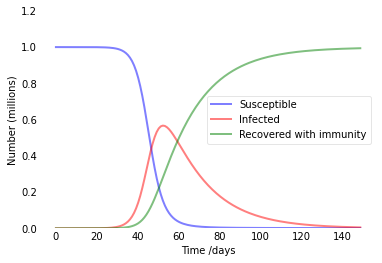

In [80]:
N = 1000000
S,I,R, t = model_SIR(N)
plot_SIR(S, I, R, t, N)

In [81]:
def get_best_SIR(loc):
    # In thousands:
    populations = {
        'China': 1400000,
        'India': 1360000,
        'US': 330000,
        'Indonesia': 267000,
        'Pakistan': 220000,
        'Brazil': 212000,
        'Nigeria': 206000,
        'Bangladesh': 168000,
        'Russia': 147000,
        'Mexico': 127000,
        'Japan': 126000,
        'Philippines': 108000,
        'Egypt': 100000
    }
    if loc in populations:
        scale = populations[loc]
    else:
        scale = 100000
    
    conf = aggregate_for_locations(df, loc, how='new')['Confirmed']
    last = conf[-1]
    
    candidates = []
    
    for N in range(scale*1000, scale*100000, scale*1000):
        R0 = 0.8
        while R0 < 2.0:
            S,I,R,t = model_SIR(N, R0)
            
            # Now find the closest value in I to the last value in conf
            # We'll treat this as
            # the point of correlation. Get that date.
            best = None
            for i in range(1, len(I)):
                if I[i-1] < last < I[i]:
                    best = i
                    break
                #elif I[i-1] > I[i]:  # on the descent; no-one is there yet
                #    break
            #print(f'N {N}, R0 {R0}, lenC {len(conf)}, best {best}, lenI {len(I)}')
            if not best or best < len(conf):  # Also not a good fit as we should include the start of the curve
                R0 += 0.05
                continue

            # Calculate MSE of the two series to this point
            mse = 0
            for i in range(len(conf)):
                #print(f'lenC {len(conf)}, i {i}, best {best}, lenI {len(I)}')
                delta = I[best-i] - conf.iloc[-i-1]
                mse += delta * delta
                
            candidates.append((mse, N, R0, best))
            R0 += 0.05

    candidates.sort(key=lambda tup: tup[0])
    N = candidates[0][1]
    R0 = candidates[0][2]
    best = candidates[0][3]
    S,I,R,t = model_SIR(N, R0)
    return S, I, R, t, N, R0, best, conf


In [82]:
S, I, R, t, N, R0, best, conf = get_best_SIR('US')

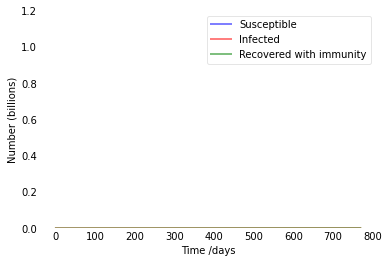

In [83]:
offset = best - len(conf)
offset = 0
plot_SIR(S[offset:], I[offset:], R[offset:], t, N)

In [84]:
pd.core.groupby.DataFrameGroupBy.corr??

In [85]:
type(np.ndarray)


type

In [86]:
import pandas._libs.tslib as ts


In [87]:
pd.errors.NullFrequencyError

pandas.errors.NullFrequencyError

In [88]:
pd.read_csv??